William Donnell-Lonon Final Project

In [4]:
#Import required data cleaning packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

#Import required ML packages
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, auc, confusion_matrix


In [5]:
#Import Data
path='/Users/williamlonon/Desktop/Principles and Techniques/Final/Covid_Data.csv'
covid_df = pd.read_csv(path)
covid_og = covid_df
print(covid_df.head())
#date_died column is in dd/mm/yyyy, and is not a datetime object.

#convert to datetime
covid_df['DATE_DIED'] = pd.to_datetime(covid_df['DATE_DIED'], format='%d/%m/%Y', errors='coerce')
print(covid_df['DATE_DIED'].isna().value_counts()) #True values are alive

#Create IS_DEAD column
covid_df['IS_DEAD'] = covid_df['DATE_DIED'].notnull().astype(int)
covid_df['IS_DEAD'] += 1

print(covid_df['IS_DEAD'].value_counts())

num_dead = 76942
num_alive = 971633
assert len(covid_df) == num_dead + num_alive
#dataframe length confirmed. hooray


   USMER  MEDICAL_UNIT  SEX  PATIENT_TYPE   DATE_DIED  INTUBED  PNEUMONIA  \
0      2             1    1             1  03/05/2020       97          1   
1      2             1    2             1  03/06/2020       97          1   
2      2             1    2             2  09/06/2020        1          2   
3      2             1    1             1  12/06/2020       97          2   
4      2             1    2             1  21/06/2020       97          2   

   AGE  PREGNANT  DIABETES  ...  ASTHMA  INMSUPR  HIPERTENSION  OTHER_DISEASE  \
0   65         2         2  ...       2        2             1              2   
1   72        97         2  ...       2        2             1              2   
2   55        97         1  ...       2        2             2              2   
3   53         2         2  ...       2        2             2              2   
4   68        97         1  ...       2        2             1              2   

   CARDIOVASCULAR  OBESITY  RENAL_CHRONIC  TOBACCO

In [123]:
#Count column values to see distribution
columns = covid_df.columns
for column in columns:
    print(covid_df[column].value_counts(), '\n')


USMER
2    662903
1    385672
Name: count, dtype: int64 

MEDICAL_UNIT
12    602995
4     314405
6      40584
9      38116
3      19175
8      10399
10      7873
5       7244
11      5577
13       996
7        891
2        169
1        151
Name: count, dtype: int64 

SEX
1    525064
2    523511
Name: count, dtype: int64 

PATIENT_TYPE
1    848544
2    200031
Name: count, dtype: int64 

DATE_DIED
2020-07-06    1000
2020-07-07     996
2020-07-13     990
2020-06-16     979
2020-07-16     938
              ... 
2021-02-26       1
2021-02-11       1
2021-02-10       1
2021-02-01       1
2021-04-22       1
Name: count, Length: 400, dtype: int64 

INTUBED
97    848544
2     159050
1      33656
99      7325
Name: count, dtype: int64 

PNEUMONIA
2     892534
1     140038
99     16003
Name: count, dtype: int64 

AGE
30     27010
31     25927
28     25313
29     25134
34     24872
       ...  
114        2
116        2
111        1
121        1
113        1
Name: count, Length: 121, dtype: int64 

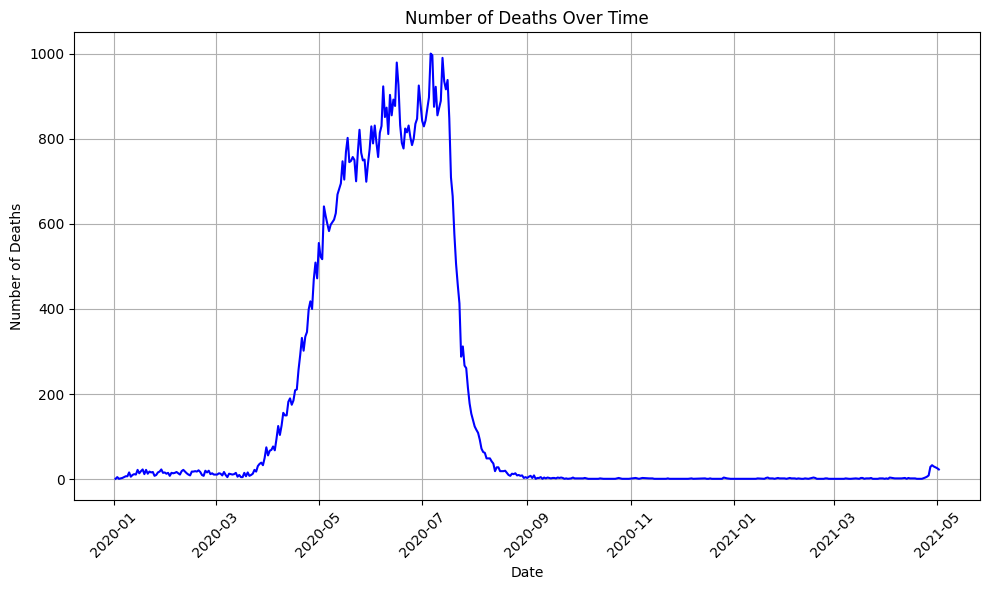

In [124]:
#Construct graph of deaths over time

death_counts = covid_df['DATE_DIED'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(death_counts.index, death_counts.values, marker='none', linestyle='-', color='blue')
plt.title('Number of Deaths Over Time')
plt.xlabel('Date')
plt.ylabel('Number of Deaths')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.show()

# The number of deaths follows a unimodal distribution with a peak in summer 2020

In [43]:
def plot_correlations(df, target_col, exclude=None, num_colored = 5):
    """
    Purpose:    To calculate and plot correlation strengths of all features against a target feature.

    Params:     df: Pandas Dataframe

                target_col: Feature one wishes to calculate correlations against

                exclude: List of columns to exclude from correlation calculation (default: None)

                num_colored: The number of bars one wishes to focus attention to in the plot (Default: 5). 
    """
    num_colored = ((num_colored * -1) - 1) # prepares num_colored for use in plot

    if exclude is None:
        exclude = []  # Set exclude to an empty list if it's not provided

    df = df.copy()  # Create a copy to prevent modifying the original DataFrame

    df.loc[:, target_col] = pd.to_numeric(df[target_col], errors='coerce')  # Convert target column to numeric

    columns = [col for col in df.columns if col not in exclude]  # Exclude specified columns from the correlation calculation

    correlations = {}
    for col in columns:
        if col != target_col:
            df.loc[:, col] = pd.to_numeric(df[col], errors='coerce')  # Convert other columns to numeric
            corr = df[target_col].corr(df[col])
            correlations[col] = corr

    sorted_correlations = sorted(correlations.items(), key=lambda x: abs(x[1]), reverse=False)

    # Plotting the top 5 correlations with the top 5 colored blue at the top
    plt.figure(figsize=(8, 6))
    bars = plt.barh([col[0] for col in sorted_correlations], [col[1] for col in sorted_correlations], color='grey')
    for i in range(-1, num_colored, -1):
        bars[i].set_color('skyblue')

    plt.title(f'Correlations with {target_col}')
    plt.xlabel('Correlation Strength')
    plt.ylabel('Variables')
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()


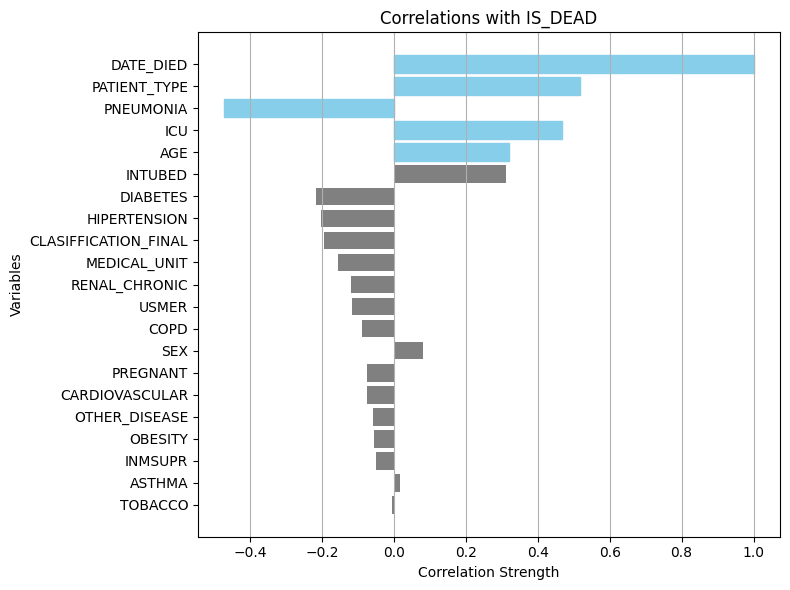

In [44]:
plot_correlations(covid_df, "IS_DEAD")

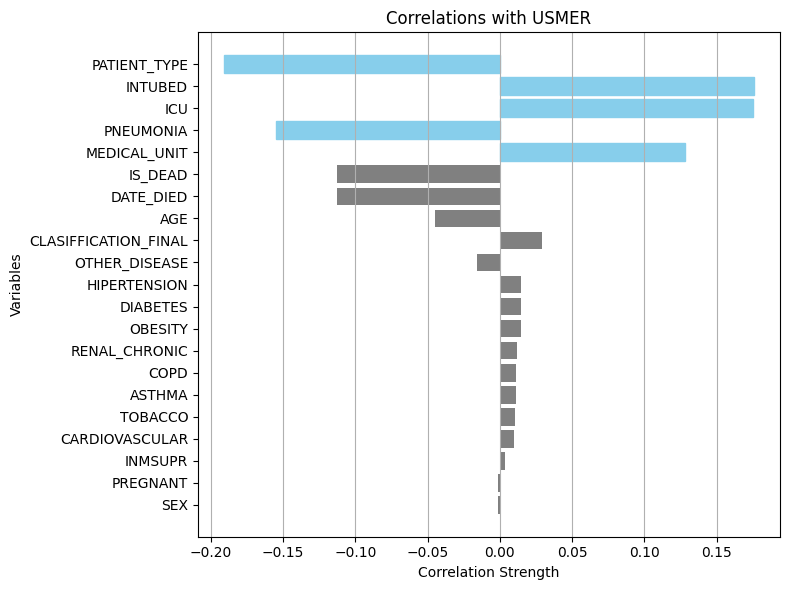

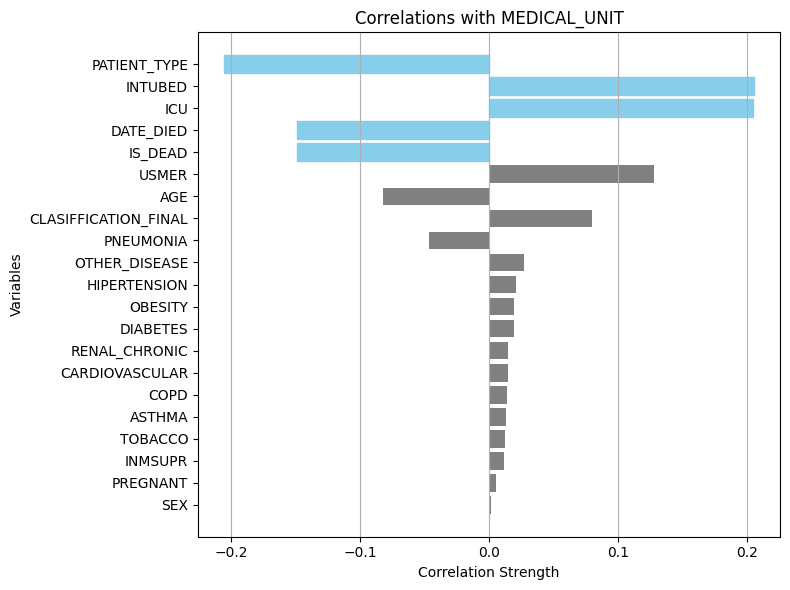

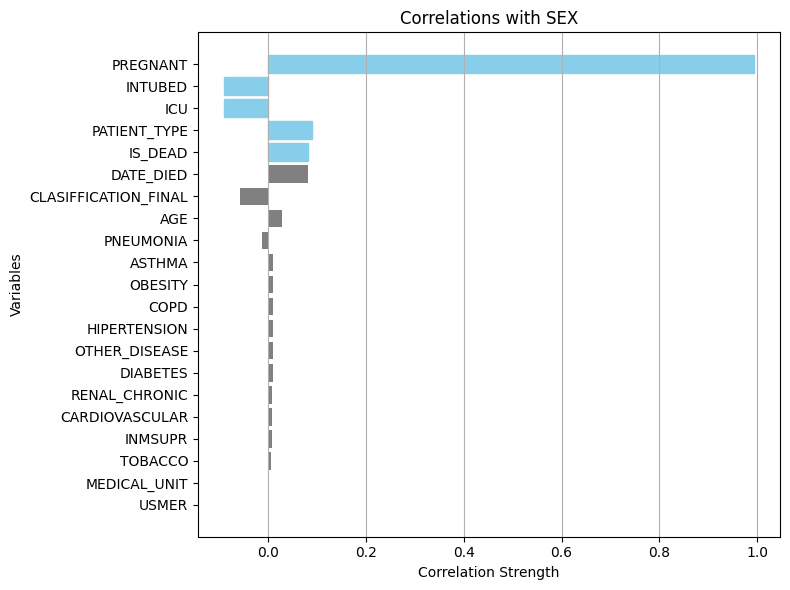

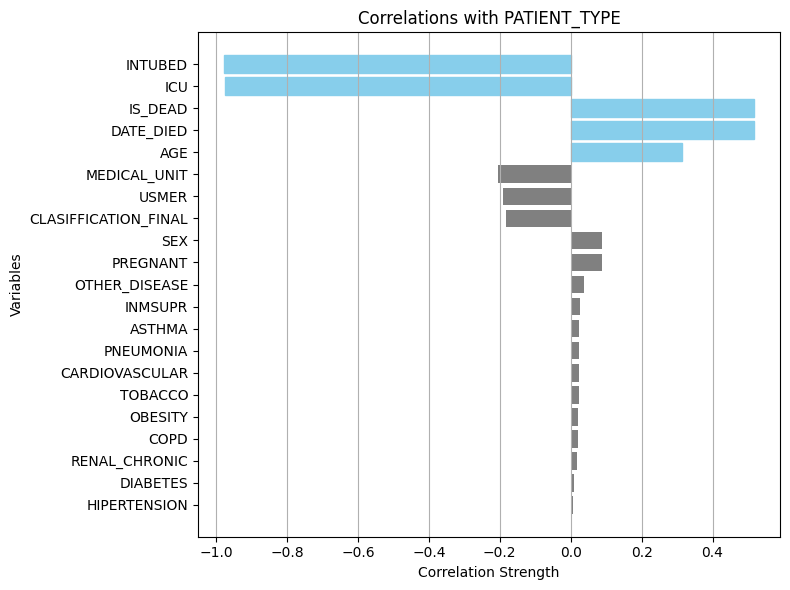

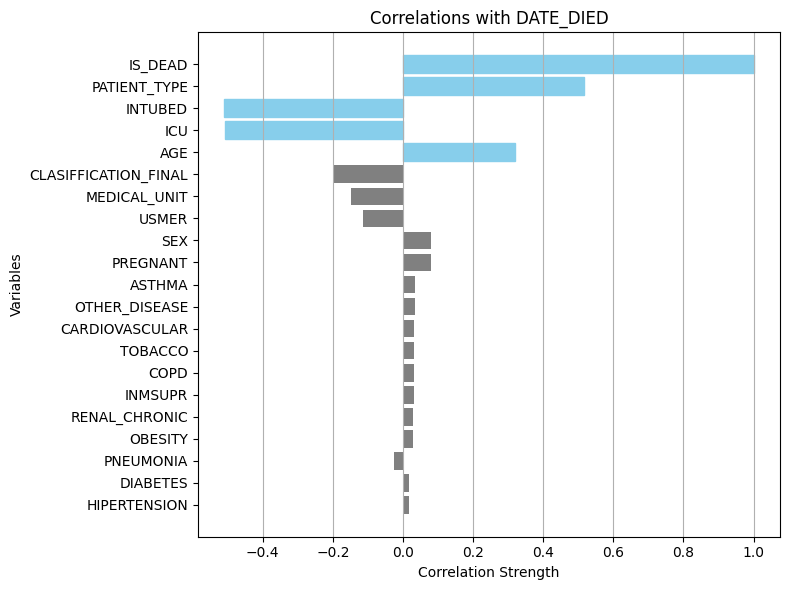

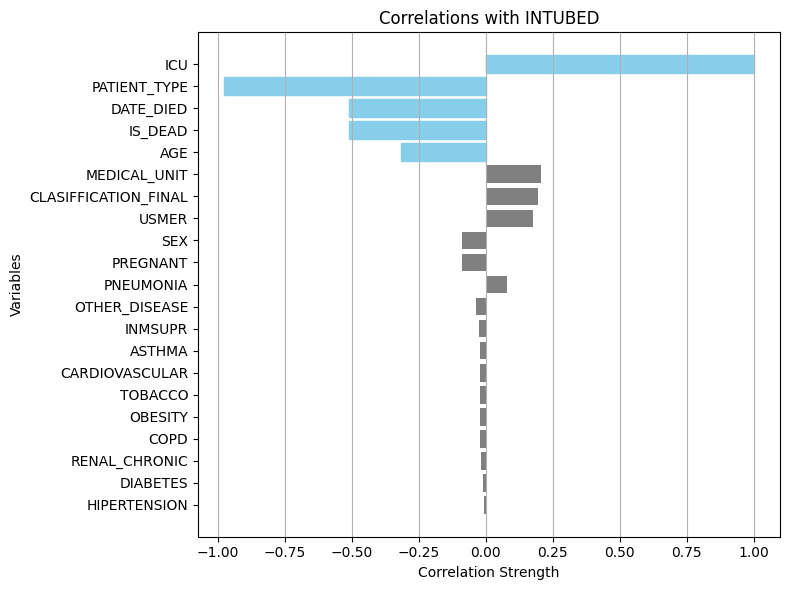

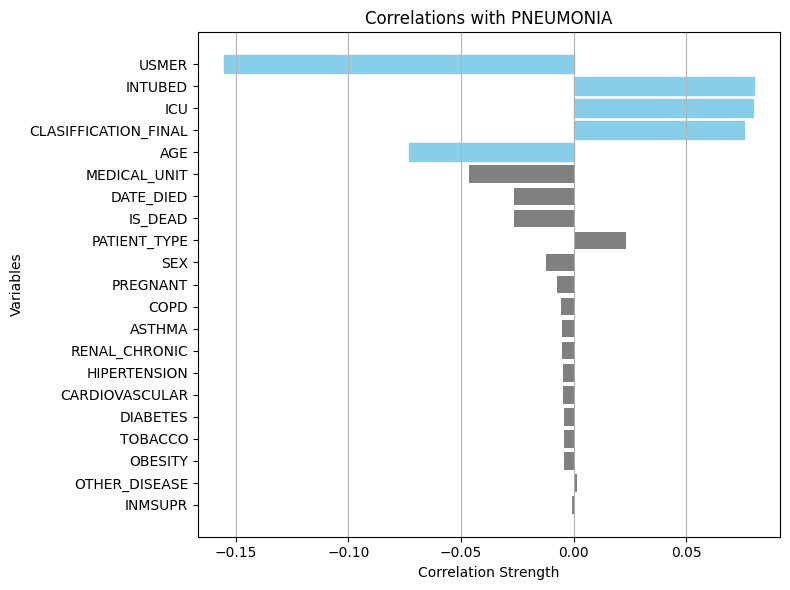

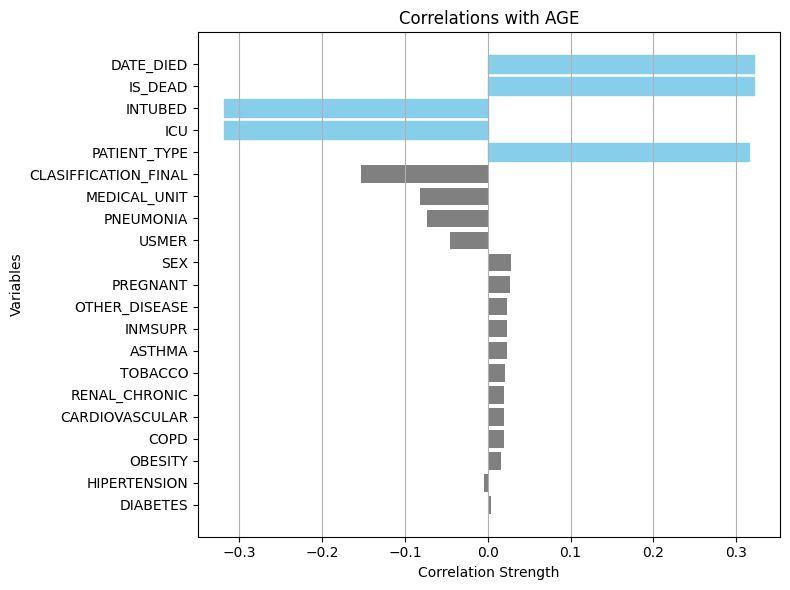

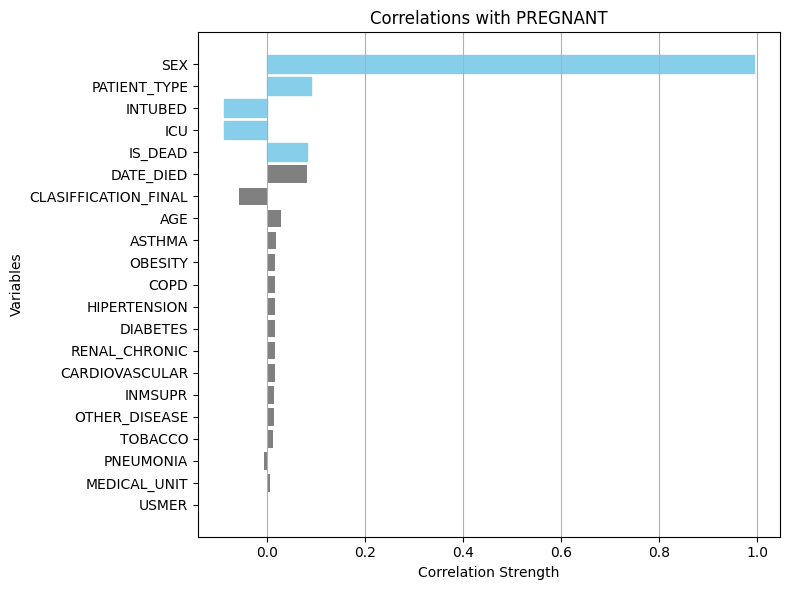

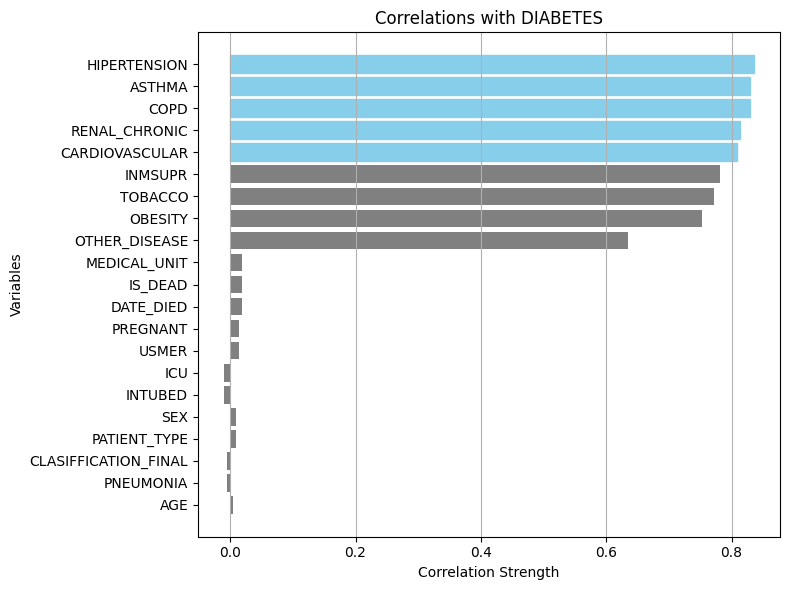

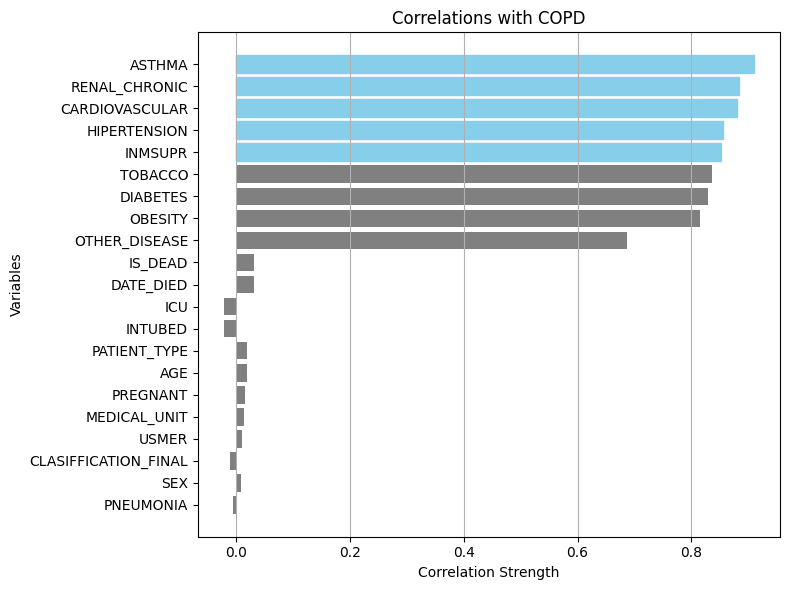

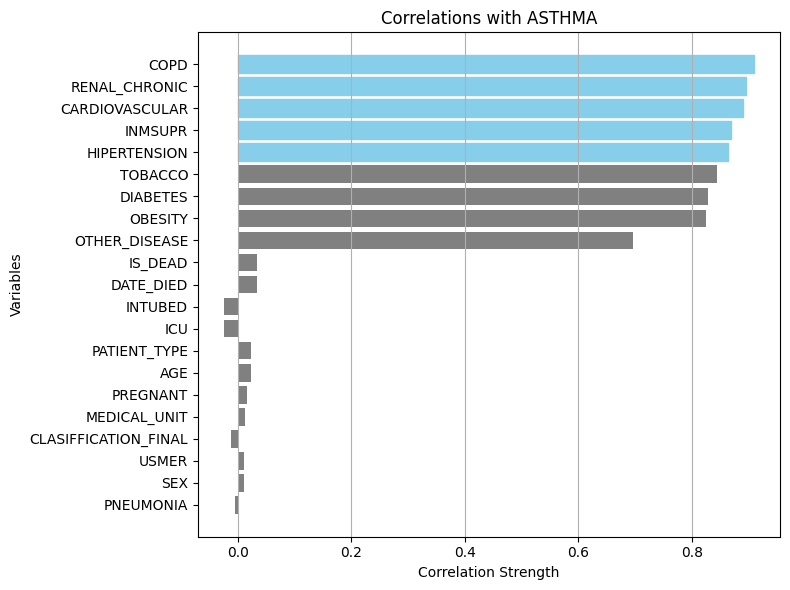

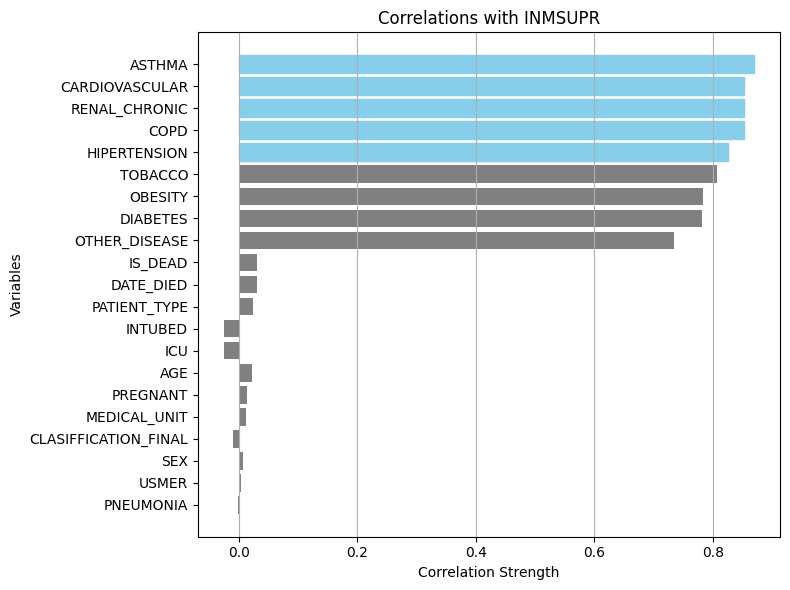

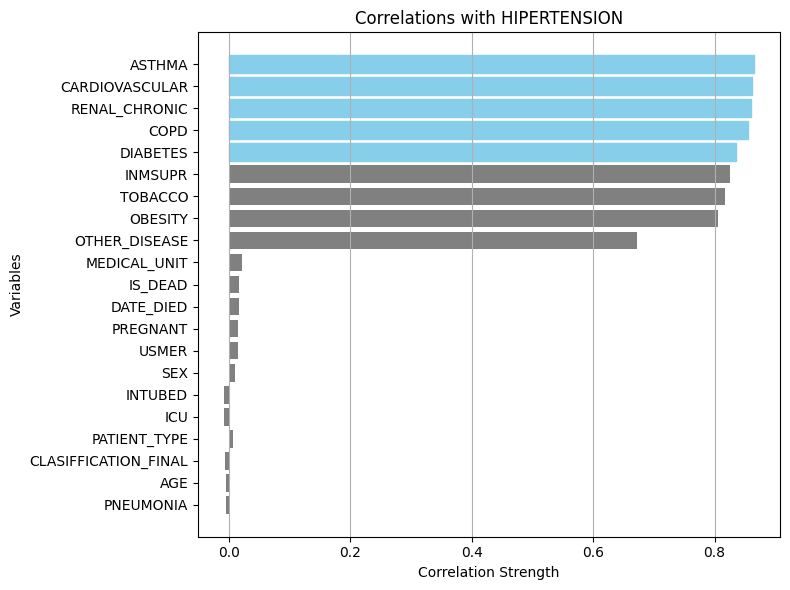

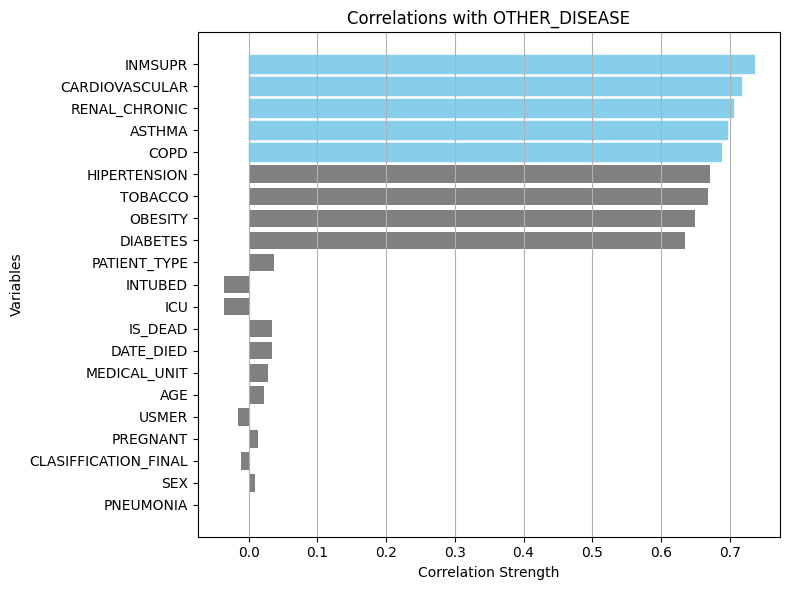

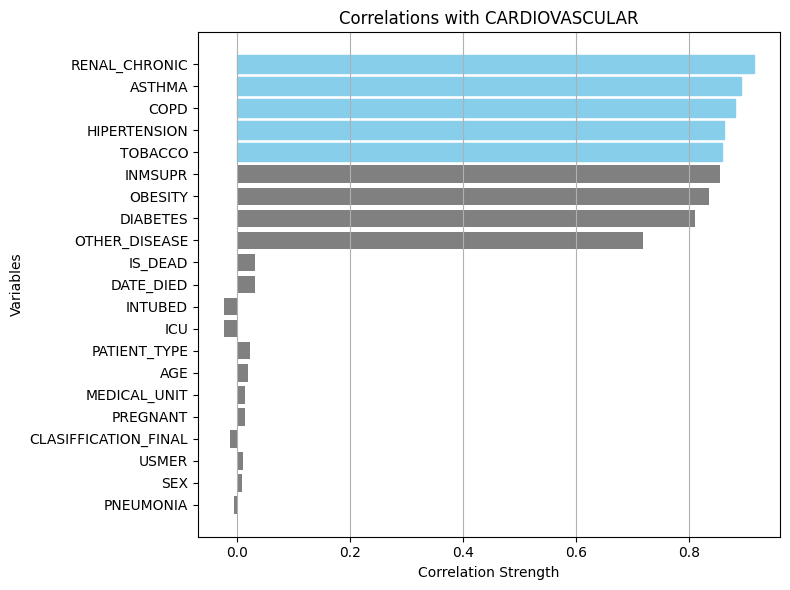

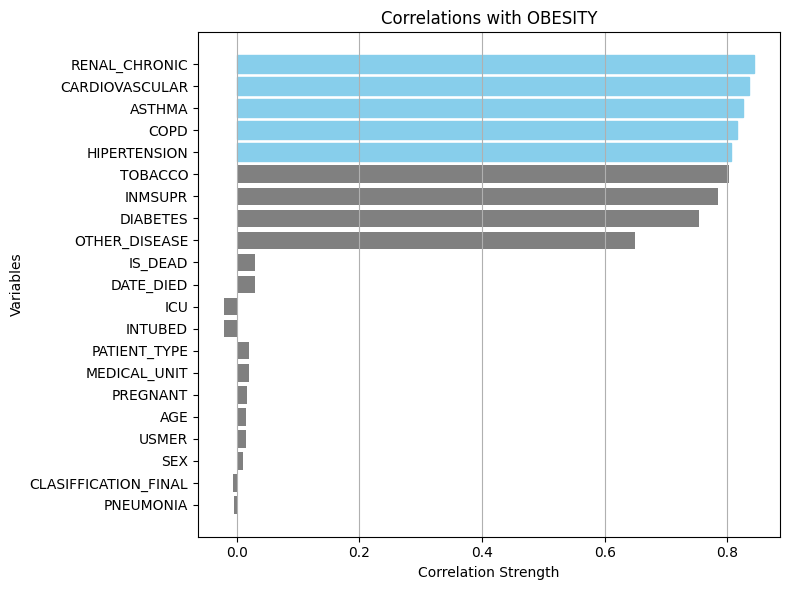

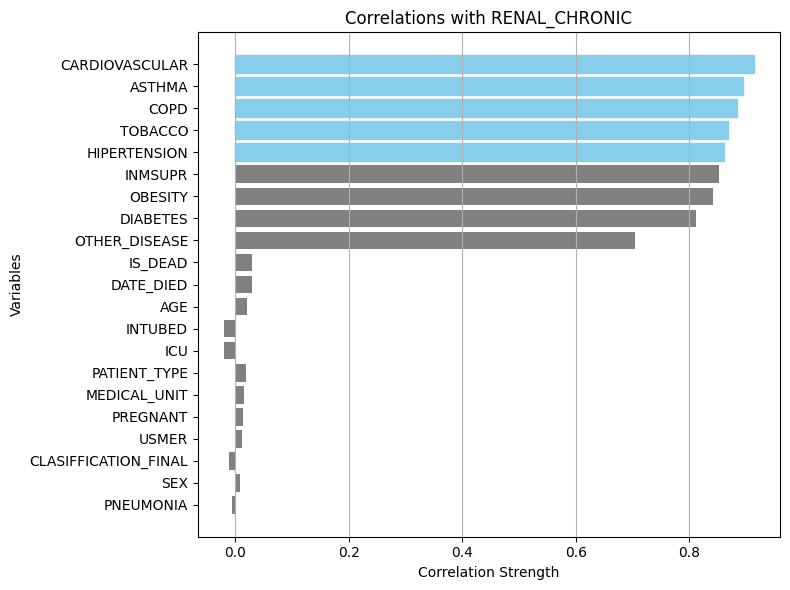

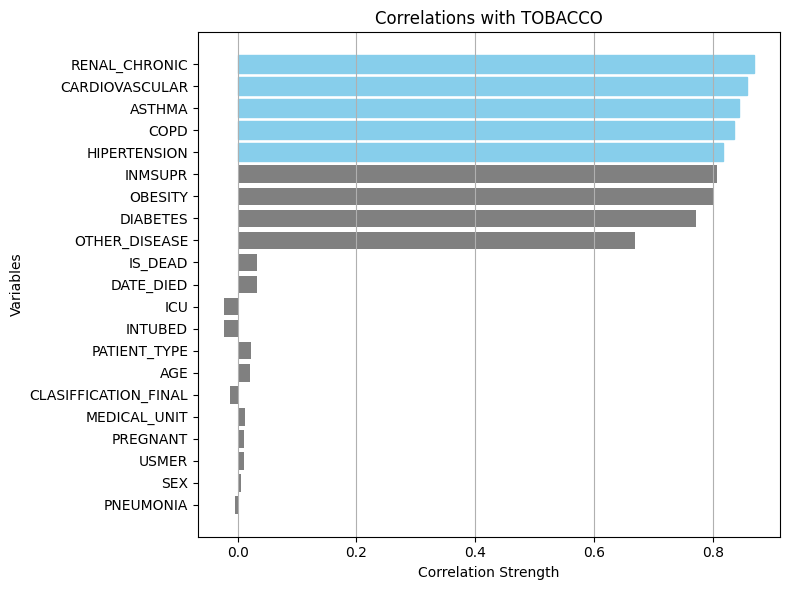

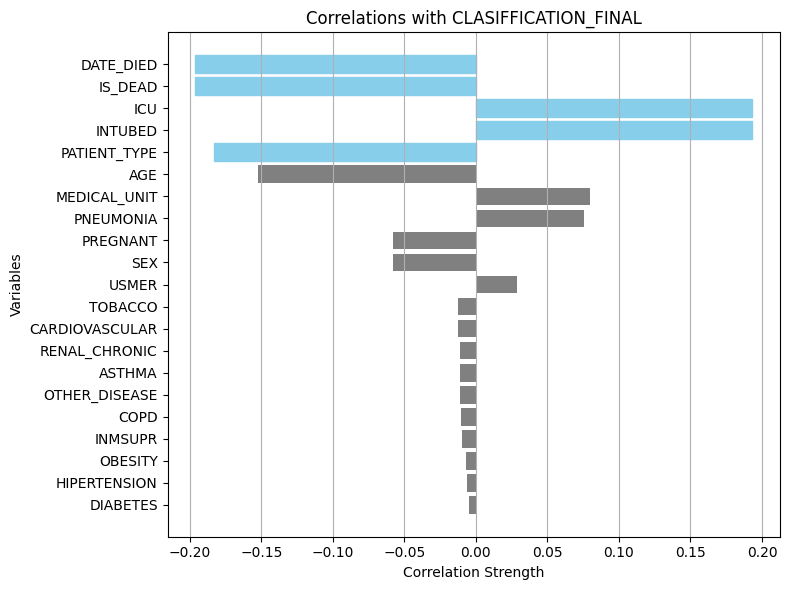

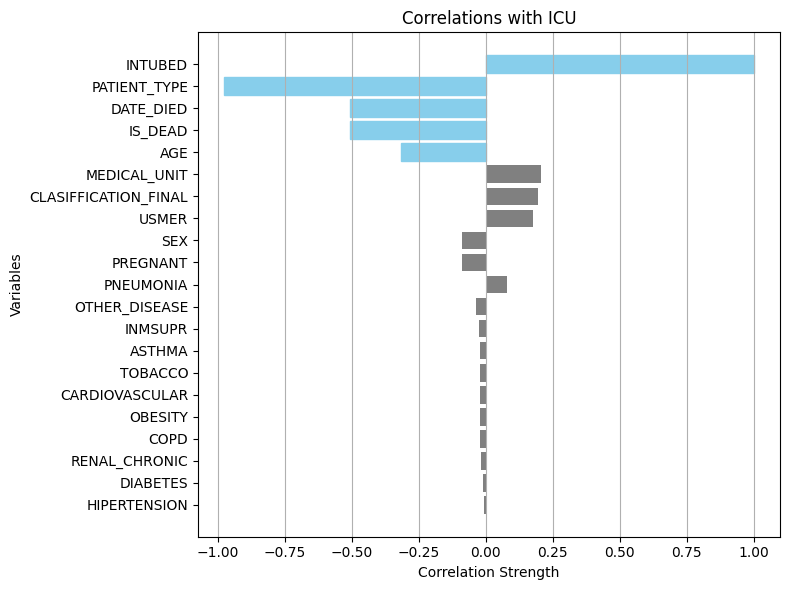

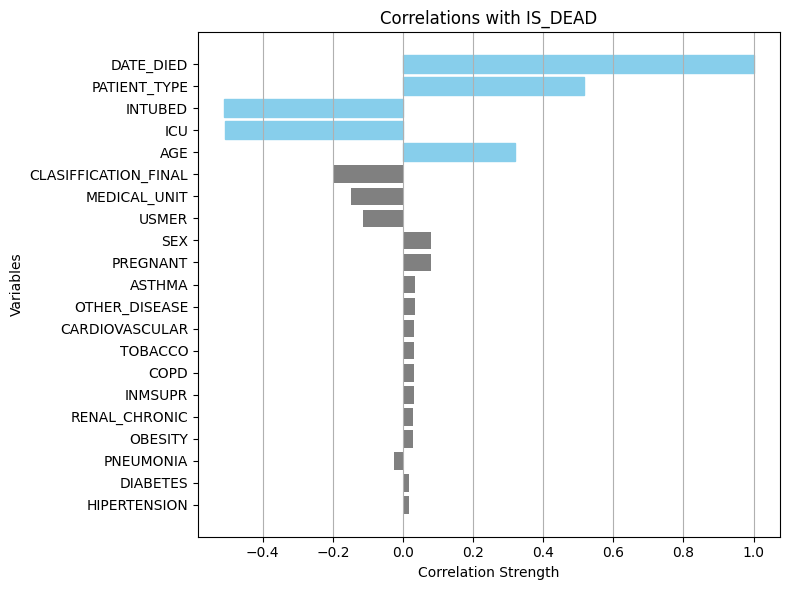

"\nInsights gained from the graphs below:\nComorbidity correlations between Chronic Renal, COPD, Obesity, Diabetes, Athsma, Cardiovasular, Tobacco, IMSUPR, Hypertension, and Other Diseases seem to be quite high. \nLet's make sure that this isn't because of missing data stored as 97,98,99.\n"

In [127]:
columns = covid_df.columns.tolist()
for col in columns: 
    plot_correlations(covid_df, col)

"""
Insights gained from the graphs below:
Comorbidity correlations between Chronic Renal, COPD, Obesity, Diabetes, Athsma, Cardiovasular, Tobacco, IMSUPR, Hypertension, and Other Diseases seem to be quite high. 
This is likely due to missing values stored as 97, 98, and 99 skewing the data. Let's do some exploration to take care of these values.
"""


In [7]:
def identify_bruh(df):
    # Identifies all bruh moments (97, 98, 99) and puts them into a df
    exclude_columns = ['AGE']  # Avoid adding non-problematic old people
    mask = (df.drop(columns=exclude_columns).isin([97, 98, 99])).any(axis=1) # look for problematic values in all columns
    filtered_df = df[mask] 
    return filtered_df

def drop_missing(df):
    # finds problematic rows and yanks them from the df
    exclude_columns = ['AGE']  # Avoid dropping reliable old people
    mask = (df.drop(columns=exclude_columns).isin([97, 98, 99])).any(axis=1)
    filtered_df = df[~mask]
    return filtered_df

bruh = identify_bruh(covid_df)
for col in bruh.columns:
    print(bruh[col].value_counts(), '\n')

"""
From close inspection of bruh moments, ICU and INTUBED columns have a majority of their values being problematic.
This is because if PATIENT_TYPE = 1 they get sent home, meaning no ICU or intubage. 
We shall replace problematic values with 1 (no icu or tubes at home)
Also, all males have problem values for PREGNANT. Since males are incapable of pregnancy, we shall replace with 1. 
"""


def male_no_preggy(df):
    # Filtering rows where PREGNANT column has problematic values and the individual is male (SEX = 2)
    problematic_rows = df[(df['PREGNANT'].isin([97, 98, 99])) & (df['SEX'] == 2)]

    # Replacing problematic values (97, 98, 99) in PREGNANT column for male individuals with 1
    df.loc[problematic_rows.index, 'PREGNANT'] = 1

    return df


def fix_icu_intubed(df):
    # Replaces 'ICU' and 'INTUBED' values with 1 for rows where 'PATIENT_TYPE' is 1
    df.loc[df['PATIENT_TYPE'] == 1, ['ICU', 'INTUBED']] = 1
    
    return df

covid_df = male_no_preggy(covid_df)
covid_df = fix_icu_intubed(covid_df)
covid_df = drop_missing(covid_df)

print("Num dropped rows:", len(covid_og) - len(covid_df))
# After filtering our data, we drop 28909 rows. Not bad! 

USMER
2    628200
1    343543
Name: count, dtype: int64 

MEDICAL_UNIT
12    576969
4     278201
9      34969
6      34640
3      17523
8       9170
10      6649
5       6549
11      5116
13       894
7        772
2        150
1        141
Name: count, dtype: int64 

SEX
2    523511
1    448232
Name: count, dtype: int64 

PATIENT_TYPE
1    848544
2    123199
Name: count, dtype: int64 

DATE_DIED
2020-07-13    682
2020-07-06    674
2020-06-16    672
2020-07-14    658
2020-07-07    657
             ... 
2021-02-11      1
2021-02-10      1
2021-02-06      1
2021-02-05      1
2021-04-22      1
Name: count, Length: 378, dtype: int64 

INTUBED
97    848544
2      93865
1      22009
99      7325
Name: count, dtype: int64 

PNEUMONIA
2     859331
1      96409
99     16003
Name: count, dtype: int64 

AGE
30     26209
31     25174
28     24620
29     24464
34     24107
       ...  
118        2
111        1
121        1
115        1
113        1
Name: count, Length: 121, dtype: int64 

PREGNANT


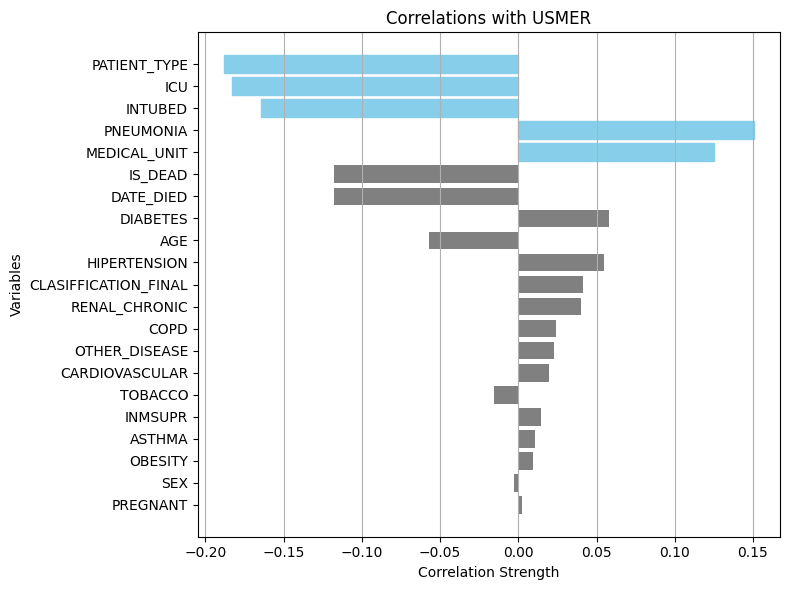

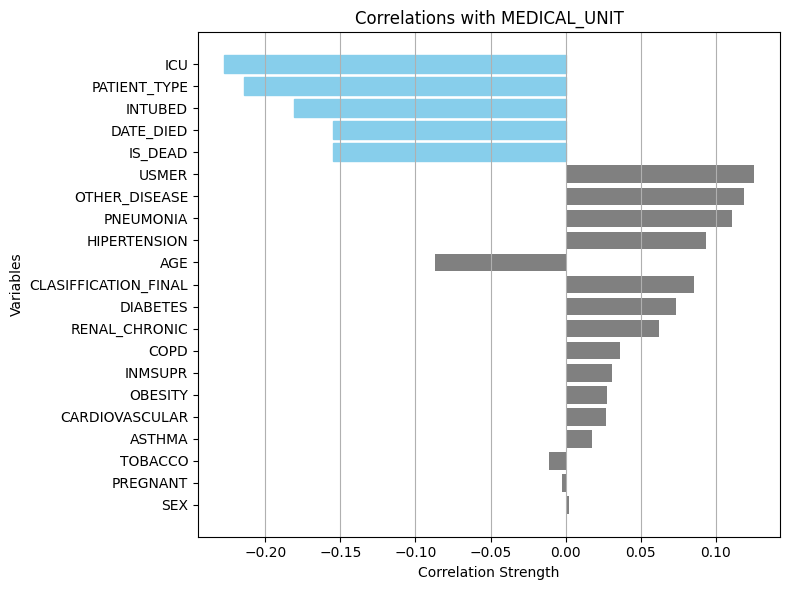

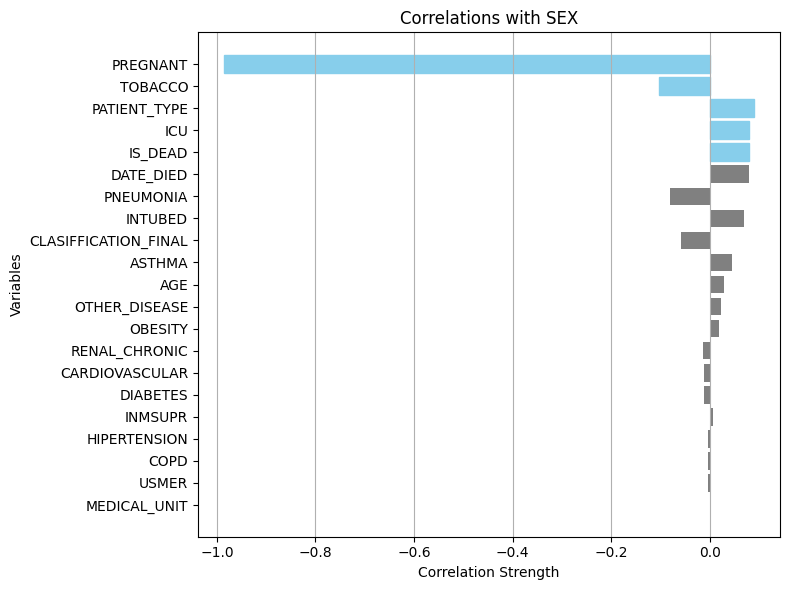

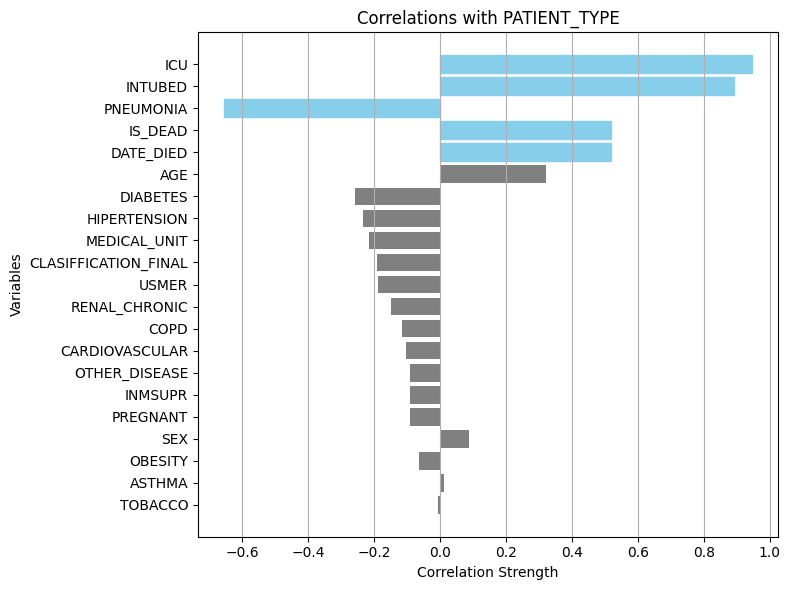

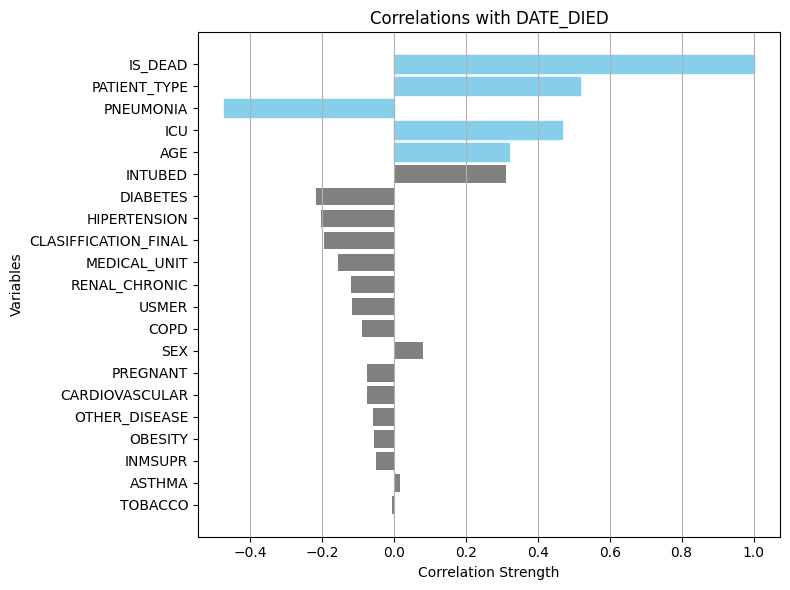

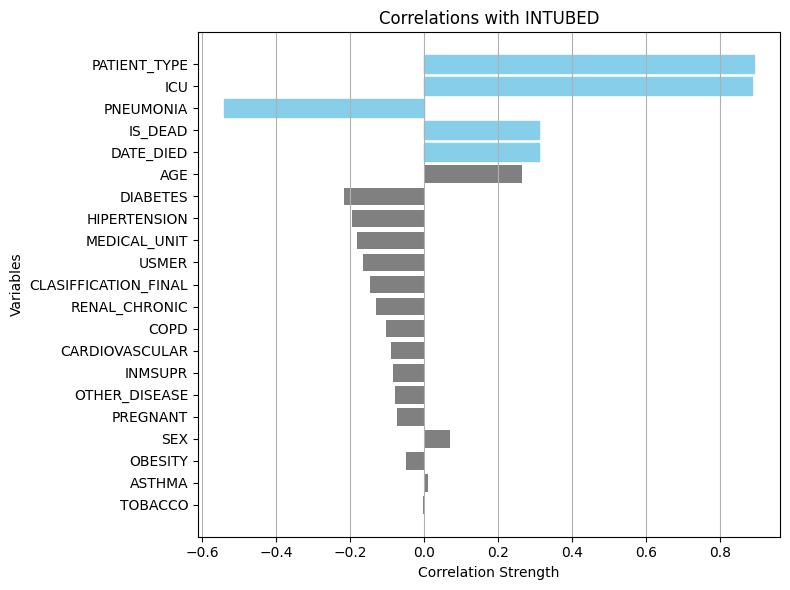

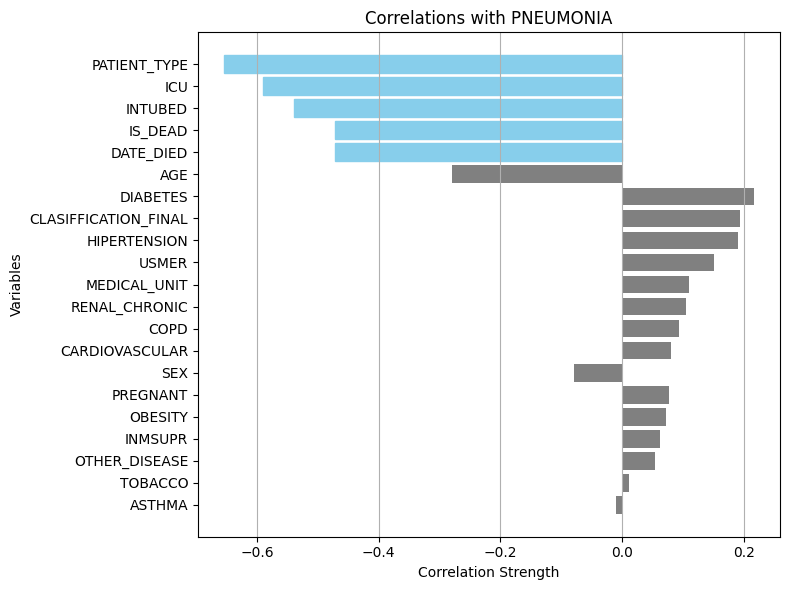

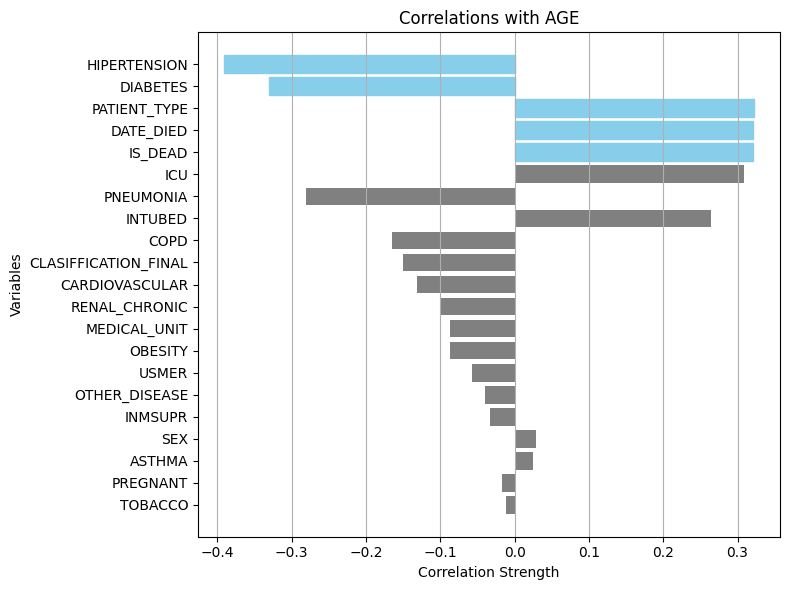

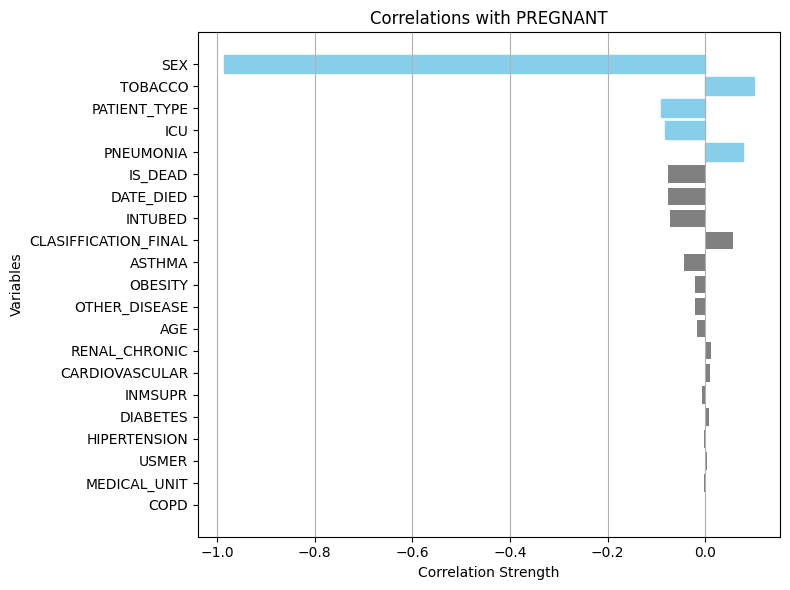

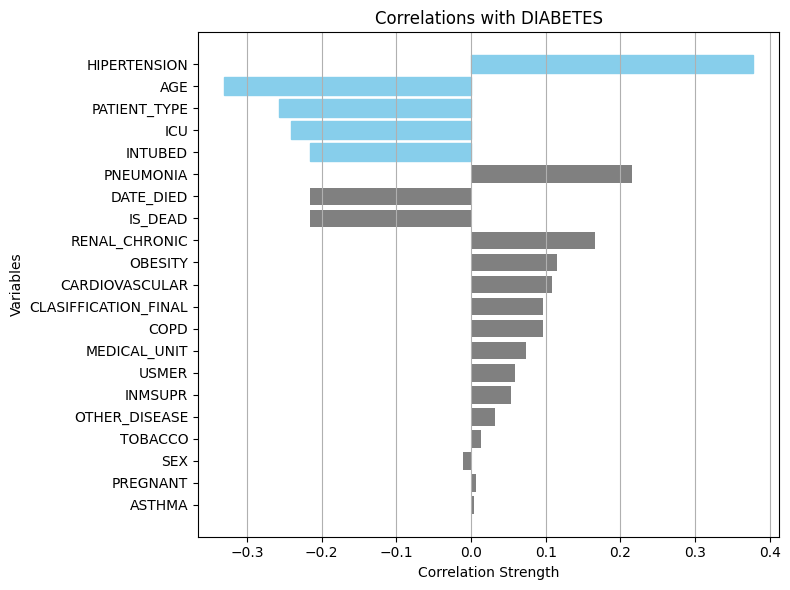

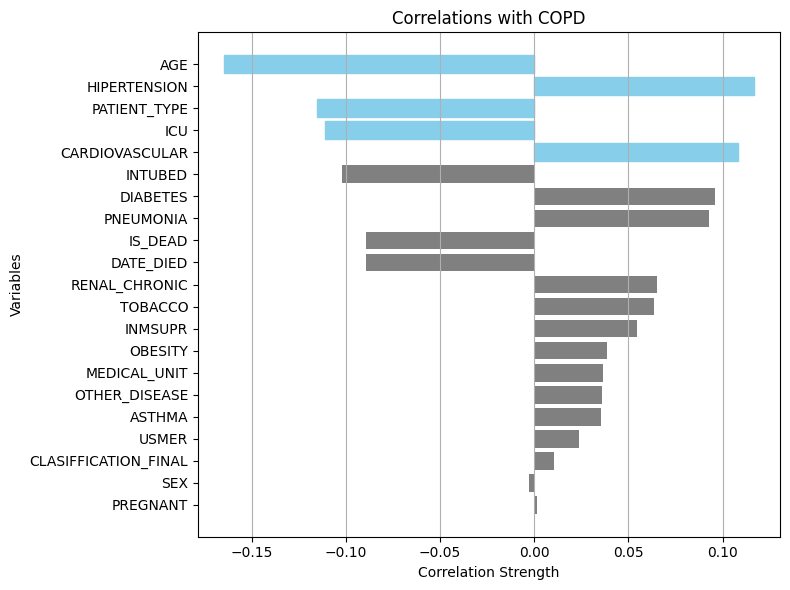

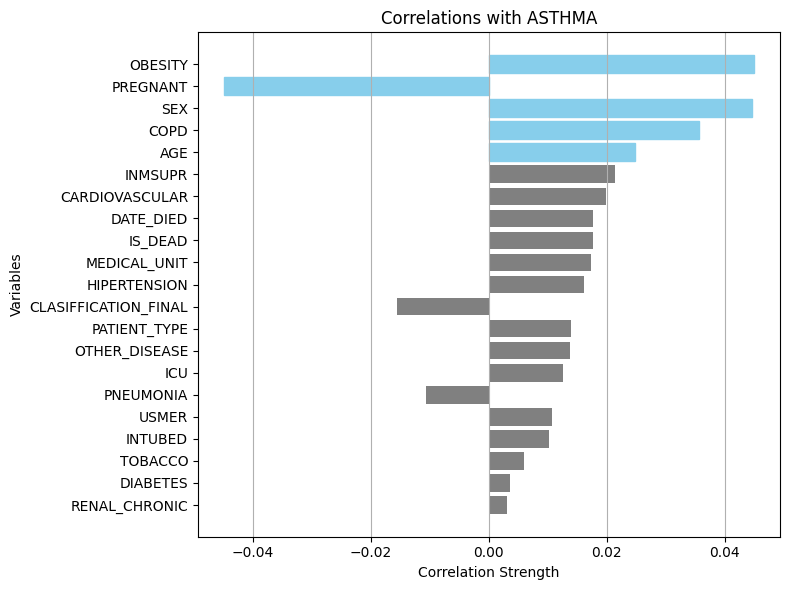

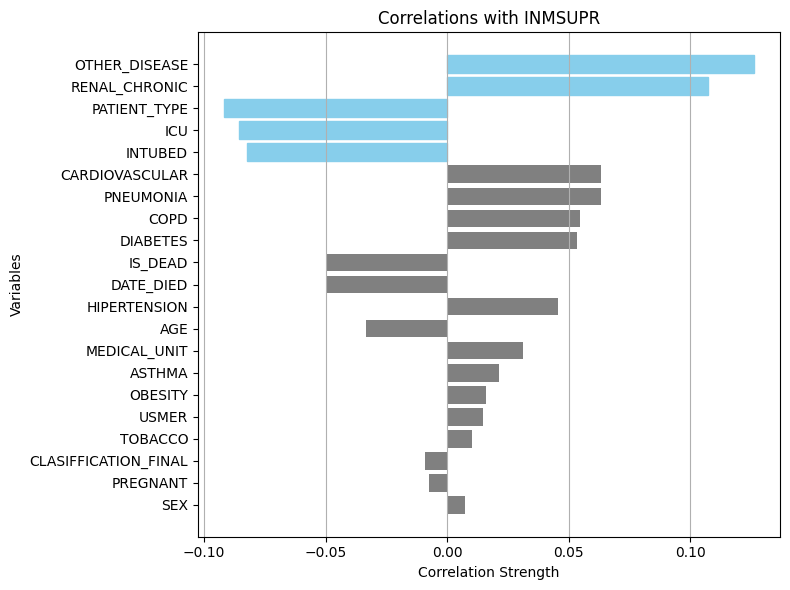

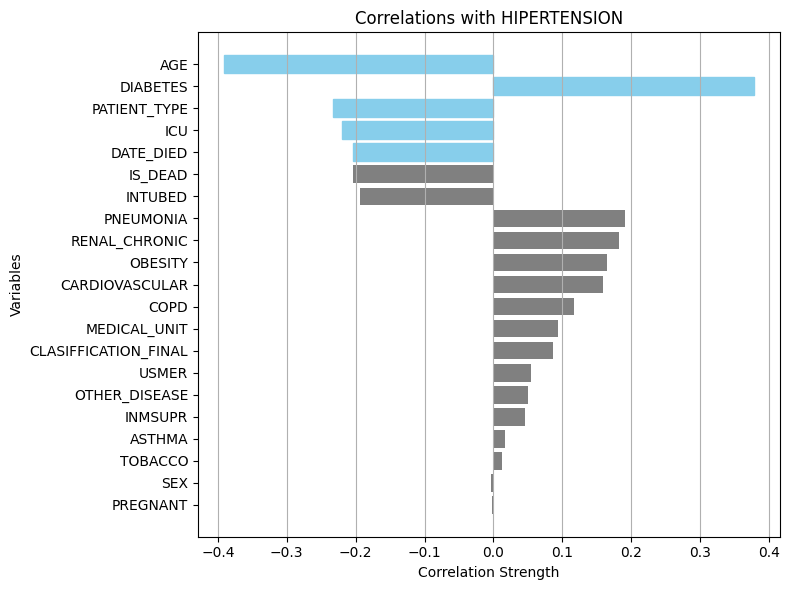

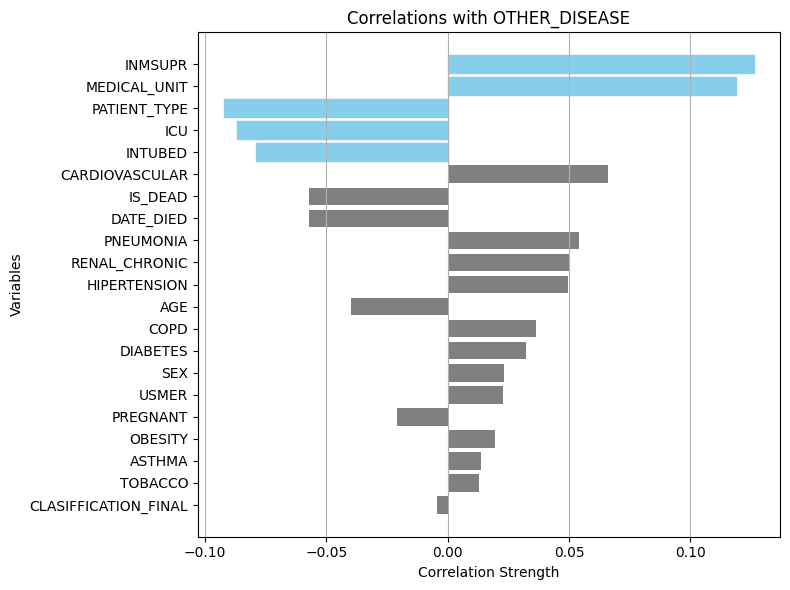

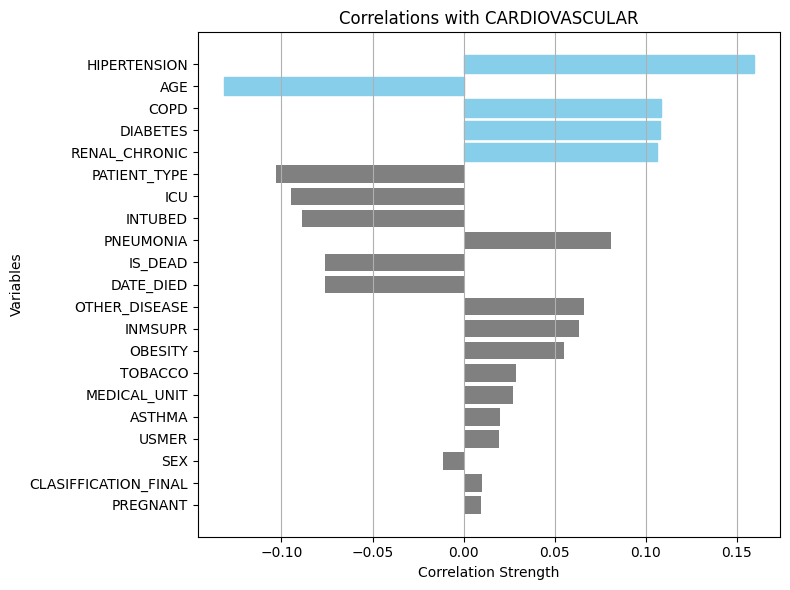

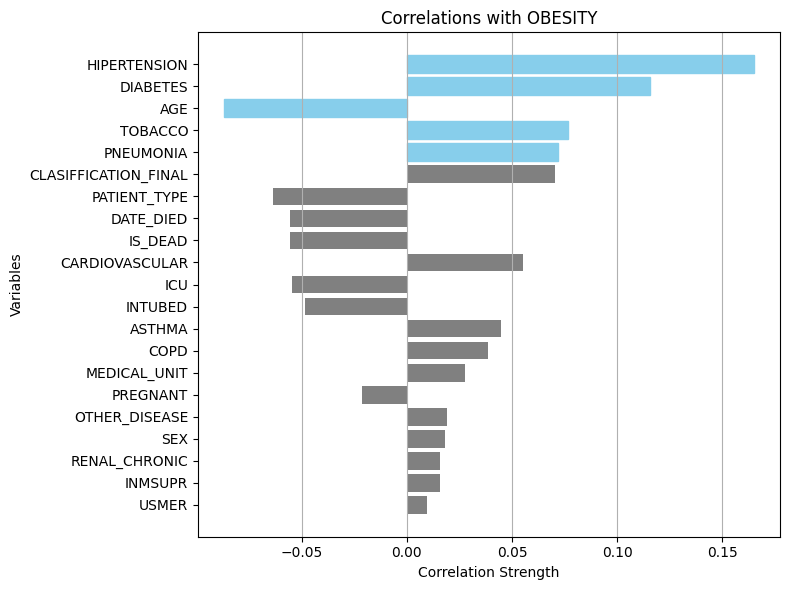

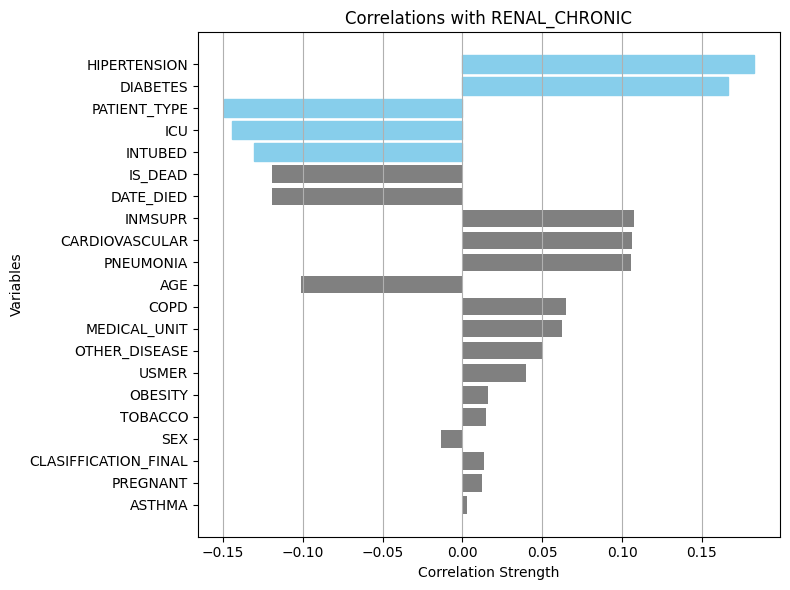

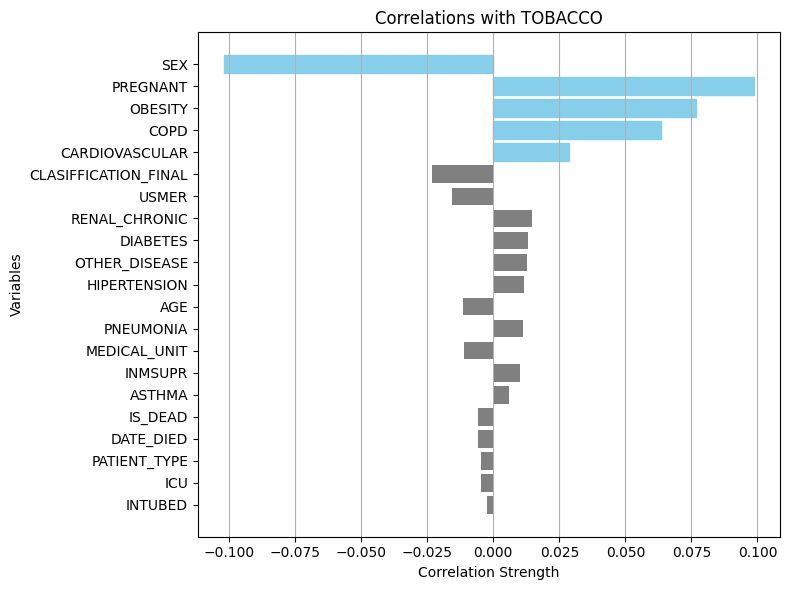

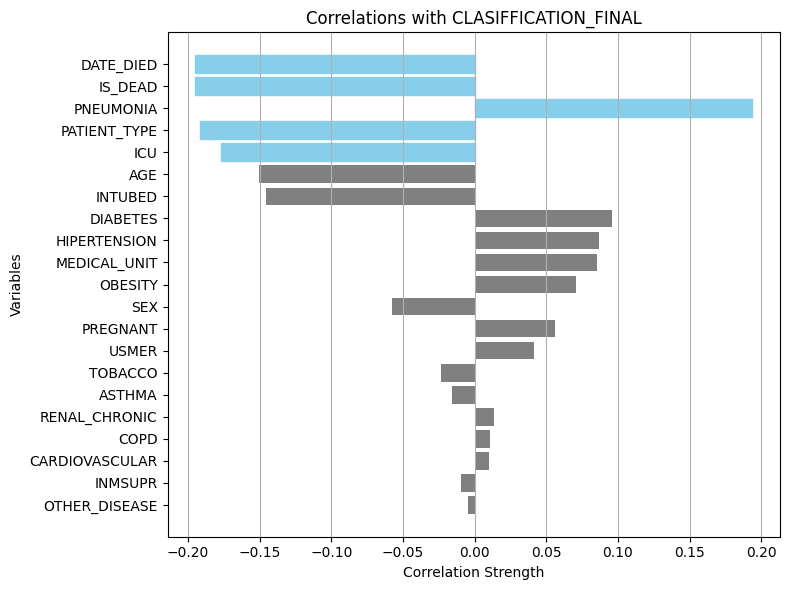

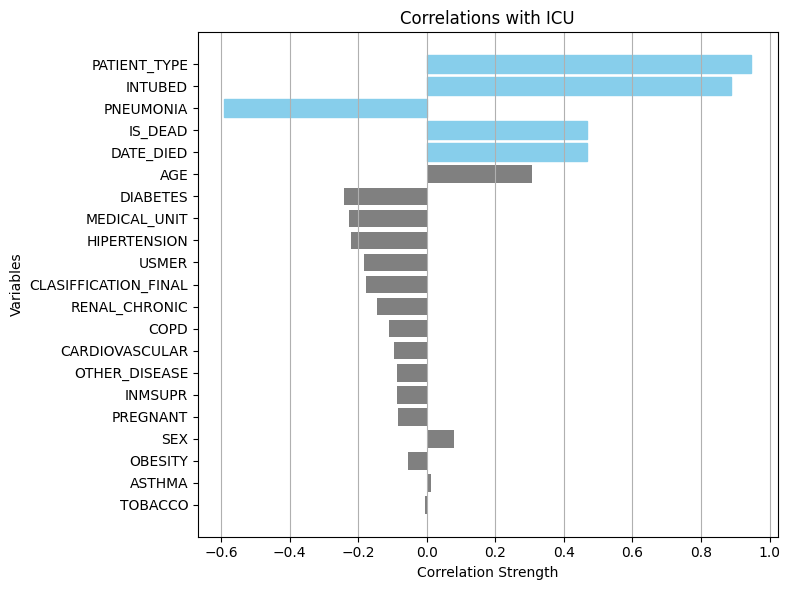

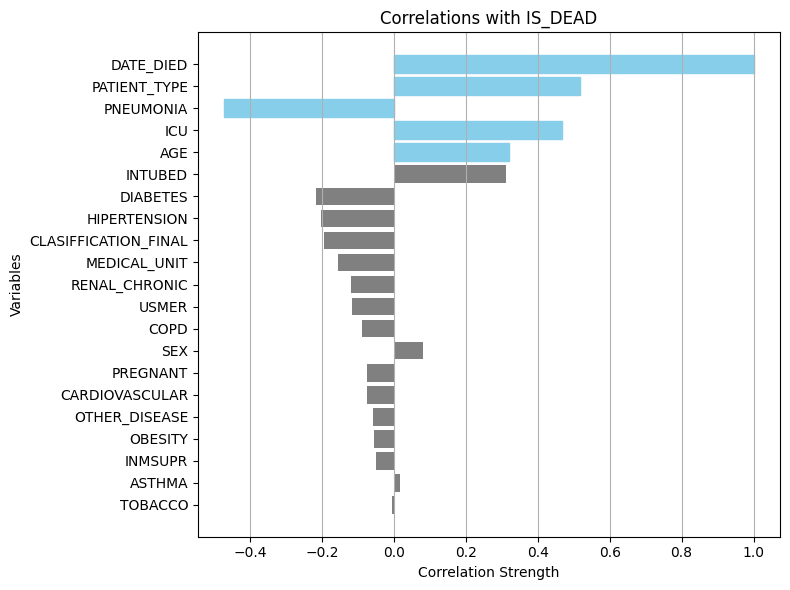

In [97]:
# New filtered df show us different insights. I find IS_DEAD an interesting target. Patient type, pneumonia, ICU, age, intubed... Makes sense; they're all indicative of a very bad reaction to covid. 
# Interesting difference from before cleaning the data... pneumonia was originally terribly uncorrelated, now it is 2nd highest correlation. 
columns = covid_df.columns.tolist()
for col in columns: 
    plot_correlations(covid_df, col)

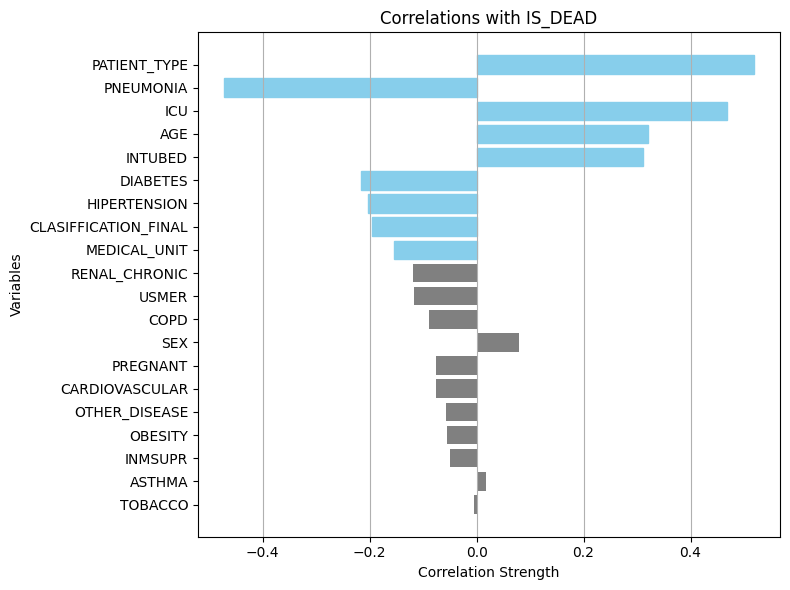

In [8]:
# It seems reasonable that IS_DEAD is a good indicator of severity. Let's use this as our model target, and the top 9 most correlated columns as predictive features. Any more and we will increase processing time; any less and we may reduce model predictability.
plot_correlations(covid_df, 'IS_DEAD', 'DATE_DIED', num_colored=9)


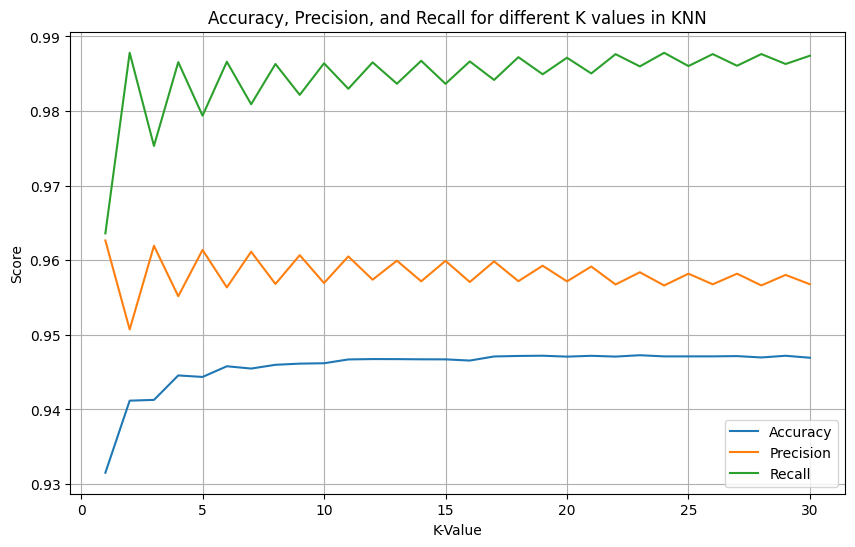

In [99]:
""" 
WARNING!!!
This cell block is very computationally intensive and will likely require AT LEAST 20 minutes to run. Go grab some lunch, or just look at the output recorded in the notebook.
Essentially, this block constructs KNN models for K = [1...30]. This allows us to tune our model to K-values that we will find to be most appropriate.
"""
# Features based on correlation
selected_features = ['PATIENT_TYPE', 'PNEUMONIA', 'ICU', 'AGE', 'INTUBED', 
                     'DIABETES', 'HIPERTENSION', 'CLASIFFICATION_FINAL', 'MEDICAL_UNIT']

# Creating subsets for features and target
X = covid_df[selected_features]
y = covid_df['IS_DEAD']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Initializing empty lists to store accuracy, precision, and recall
accuracies = []
precisions = []
recalls = []

# Parameter tuning: Evaluating at different values of K
for k in range(1, 31):
    # Initializing the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fitting the model
    knn.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = knn.predict(X_test)
    
    # Calculating accuracy, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Appending to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), accuracies, label='Accuracy')
plt.plot(range(1, 31), precisions, label='Precision')
plt.plot(range(1, 31), recalls, label='Recall')
plt.xlabel('K-Value')
plt.ylabel('Score')
plt.title('Accuracy, Precision, and Recall for different K values in KNN')
plt.legend()
plt.grid()
plt.show()

"""
This graph provides insights as to how we may tune our model. Depending on how we want to optimize our model's predictive capacity, we will choose an appropriate K-value. 
For instance, if we want to optimize to reduce false negatives (mischaracterizing a patient as NOT at risk when they truly ARE), we would choose a K-value that produces high recall.
Interestingly, this graph suggests that odd/even values for K oscillate between favoring precision/recall. Also worth noting is that as K increases, recall slowly increases, and precision slowly decreases.
Since our intention is to save the most lives by successfully predicting who is most at-risk for dying, we want a high recall. Therefore, without sacrificing much precision, I will be choosing a K-value of 24. 
"""

In [114]:
# Create KNN model with K = 24

# Features with highest correlation with target column
selected_features = ['PATIENT_TYPE', 'PNEUMONIA', 'ICU', 'AGE', 'INTUBED', 
                     'DIABETES', 'HIPERTENSION', 'CLASIFFICATION_FINAL', 'MEDICAL_UNIT']

# Creating subsets for features and target
X = covid_df[selected_features]
y = covid_df['IS_DEAD'] 

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Initializing the KNN classifier
knn = KNeighborsClassifier(n_neighbors=24, n_jobs=-1)

# Perform 10-fold cross-validation
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='recall')
print("Cross-validation scores:", cv_scores)
print("Mean recall:", cv_scores.mean())

# Fit the model on the entire training set
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)

"""
By performing cross-validation, we find an average recall of approximately 0.988, suggesting that the model is performing exceptionally well in identifying positive instances (in this case, predicting patients who are at risk of death). A high average recall indicates that the model is adept at capturing the majority of positive cases within the dataset.
However, while a high recall score is favorable, it's crucial to consider the context of the application. In healthcare or medical contexts, especially when dealing with life-threatening situations, maximizing recall (minimizing false negatives) is crucial. It's more important to capture as many true positive cases as possible, even if it results in more false positives.
Therefore, a high recall score is generally encouraging, but it should be balanced with other metrics like precision, accuracy, and the specific goals and requirements of the application.
"""


Cross-validation scores: [0.98766699 0.98786323 0.98793871 0.98754623 0.98747075 0.98753113
 0.988301   0.98766699 0.98848215 0.98792362]
Mean recall: 0.9878390821948827


Confusion Matrix:
[[280445   3461]
 [ 12719   9275]]
Precision: 0.9566
Recall: 0.9878
Accuracy: 0.9471


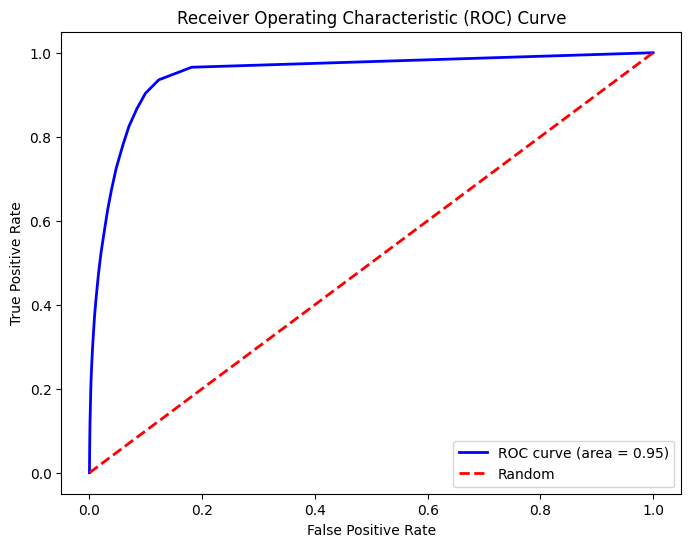

" \nThe confusion matrix provides a breakdown of the model's predictions against the actual outcomes. In this scenario:\n\nPrecision is high (0.9599), indicating that when the model predicts a death, it is correct about 96% of the time.\nRecall is also high (0.9837), suggesting that the model identifies 98% of actual deaths correctly.\nAccuracy stands at 0.9467, which is the overall proportion of correctly predicted outcomes.\nHowever, the difference in the distribution of true values (a significantly larger number of true alive cases compared to true dead cases) can influence the interpretation:\n\nHigh Precision indicates that among the model's predictions of death, the vast majority are correct. Given the lower number of true dead cases (relative to true alive cases), even a small number of false positives can affect Precision. Despite this, Precision is quite high, suggesting that when the model predicts death, it's often correct.\nHigh Recall suggests the model correctly identifie

In [115]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Get the predicted probabilities for the positive class
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=2)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

""" 
The confusion matrix provides a breakdown of the model's predictions against the actual outcomes. In this scenario:

Precision is high (0.9566), indicating that when the model predicts a death, it is correct about 96% of the time.
Recall is also high (0.9878), suggesting that the model identifies 98% of actual deaths correctly.
Accuracy stands at 0.9471, which is the overall proportion of correctly predicted outcomes.
However, the difference in the distribution of true values (a significantly larger number of true alive cases compared to true dead cases) can influence the interpretation:
High Precision indicates that among the model's predictions of death, the vast majority are correct. Given the lower number of true dead cases (relative to true alive cases), even a small number of false positives can affect Precision. Despite this, Precision is quite high, suggesting that when the model predicts death, it's often correct.
High Recall suggests the model correctly identifies most actual deaths. But, when there are fewer instances of the minority class (in this case, deaths), achieving high Recall can be easier as the model tends to predict the majority class (alive) more frequently. Still, the model effectively identifies a large portion of actual deaths.



Additionally, an ROC curve with an area under the curve (AUC) value of 0.95 indicates a very good performance of the model. Here's a contextual interpretation of the ROC curve based on the AUC value:

High Discrimination Ability: 
AUC values closer to 1 signify that the model has excellent discrimination ability. In this case, with an AUC of 0.95, the model is capable of distinguishing between positive and negative classes quite well.

Strong Trade-off between Sensitivity and Specificity: 
The model's ability to balance sensitivity (true positive rate) and specificity (true negative rate) is noteworthy. It means the model achieves high sensitivity without compromising its specificity or vice versa across different decision thresholds.

Good Predictive Power: 
An AUC of 0.95 indicates that the model is highly accurate and effective in distinguishing between classes. It performs significantly better than random chance (AUC = 0.5), showing its reliability in making correct predictions.

Potential Practical Implications: 
In practical applications, such a high AUC suggests the model could be beneficial for tasks that require reliable classification or prediction, like medical diagnosis and/or risk assessment.

In essence, an ROC curve with an AUC of 0.95 signifies a robust and well-performing model with strong predictive capabilities, which can make accurate classifications for the given problem.
"""

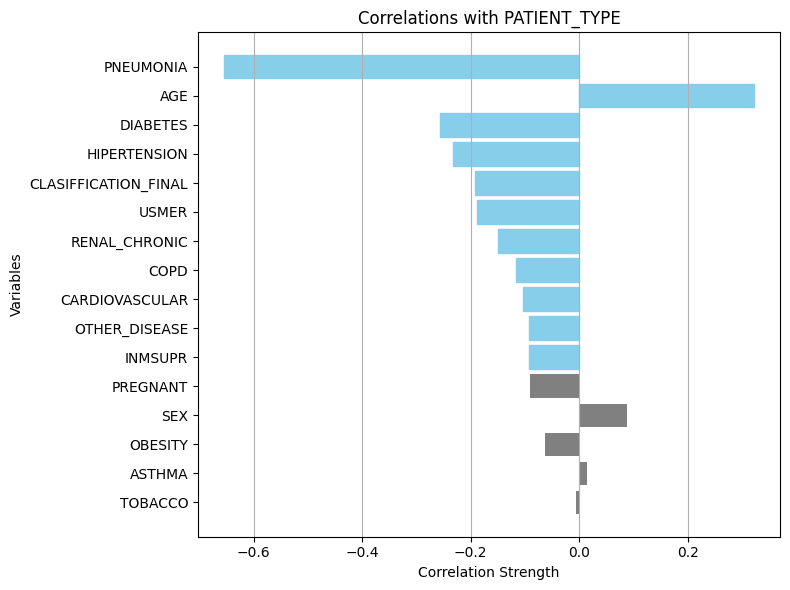

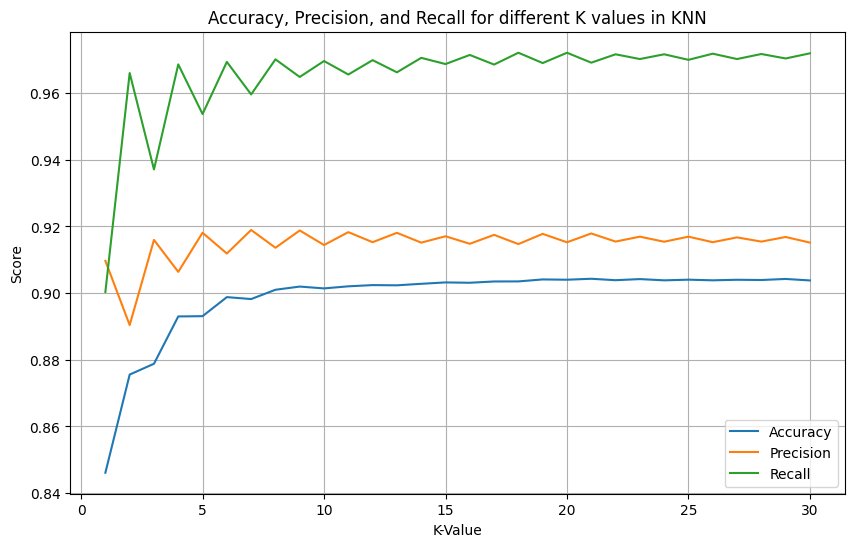

In [35]:
""" 
WARINING!!! This code cell also takes extremely long to load. Again, the output (which shouldn't change with your computation) is already printed at the bottom. 

Okay, so we have been able to accurately predict whether someone is likely to die, based primarily on their experience at the hospital, as well as part of their medical history. 
But what about assessing their risk for developing a SEVERE REACTION to COVID (One that requires hospitalization) based on only their medical history?
In order to do this, our y variable is going to be PATIENT_TYPE, and we are going to be predicting that based on their medical history and age.
Because we are predicting whether they are being hospitalized, we should not include features such as ICU or INTUBED (hospitalization is implied), or IS_DEAD/DATE_DIED (for obvious reasons, we can't save your life if it's already over.)
Our model features will be the 11 most correlated medical conditions.
"""
plot_correlations(df=covid_df, target_col='PATIENT_TYPE', exclude=['IS_DEAD', 'DATE_DIED', 'MEDICAL_UNIT', 'ICU', 'INTUBED'], num_colored= 11)



# Features based on correlation
selected_features = ['PNEUMONIA', 'AGE', 'DIABETES', 
                     'HIPERTENSION', 'CLASIFFICATION_FINAL', 'USMER', 'RENAL_CHRONIC', 'OTHER_DISEASE', 'INMSUPR', 'COPD', 'CARDIOVASCULAR']

# Creating subsets for features and target
X = covid_df[selected_features]
y = covid_df['PATIENT_TYPE']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)

# Initializing empty lists to store accuracy, precision, and recall
accuracies = []
precisions = []
recalls = []

# Parameter tuning: Evaluating at different values of K
for k in range(1, 31):
    # Initializing the KNN classifier
    knn = KNeighborsClassifier(n_neighbors=k)
    
    # Fitting the model
    knn.fit(X_train, y_train)
    
    # Predicting on the test set
    y_pred = knn.predict(X_test)
    
    # Calculating accuracy, precision, and recall
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    
    # Appending to the lists
    accuracies.append(accuracy)
    precisions.append(precision)
    recalls.append(recall)

# Plotting the graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), accuracies, label='Accuracy')
plt.plot(range(1, 31), precisions, label='Precision')
plt.plot(range(1, 31), recalls, label='Recall')
plt.xlabel('K-Value')
plt.ylabel('Score')
plt.title('Accuracy, Precision, and Recall for different K values in KNN')
plt.legend()
plt.grid()
plt.show()


""" 
According to the precision/recall/accuracy graph, we again see an oscillating pull between precision and recall, with a semi-constant accuracy.
We want to maximize recall in order to reduce false negatives, so we will be choosing a K-value of 30 for our model (precision is less important, better safe than sorry)"""



In [36]:
# Initializing the KNN classifier
knn = KNeighborsClassifier(n_neighbors=30)
    
# Creating subsets for features and target
selected_features = ['PNEUMONIA', 'AGE', 'DIABETES', 
                     'HIPERTENSION', 'CLASIFFICATION_FINAL', 'USMER', 'RENAL_CHRONIC', 'OTHER_DISEASE', 'INMSUPR', 'COPD', 'CARDIOVASCULAR']
                     
X = covid_df[selected_features]
y = covid_df['PATIENT_TYPE'] 

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=69)


# Perform 10-fold cross-validation 
cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='recall')
print("Cross-validation scores:", cv_scores)
print("Mean recall:", cv_scores.mean())

# Fit the model on the entire training set
knn.fit(X_train, y_train)

# Predicting on the test set
y_pred = knn.predict(X_test)


Cross-validation scores: [0.97282375 0.97063933 0.97210134 0.97151654 0.97210134 0.97106933
 0.97210134 0.97189494 0.97309895 0.97065603]
Mean recall: 0.9718002900910323


Confusion Matrix:
[[242006   6990]
 [ 22438  34466]]
Precision: 0.9152
Recall: 0.9719
Accuracy: 0.9038


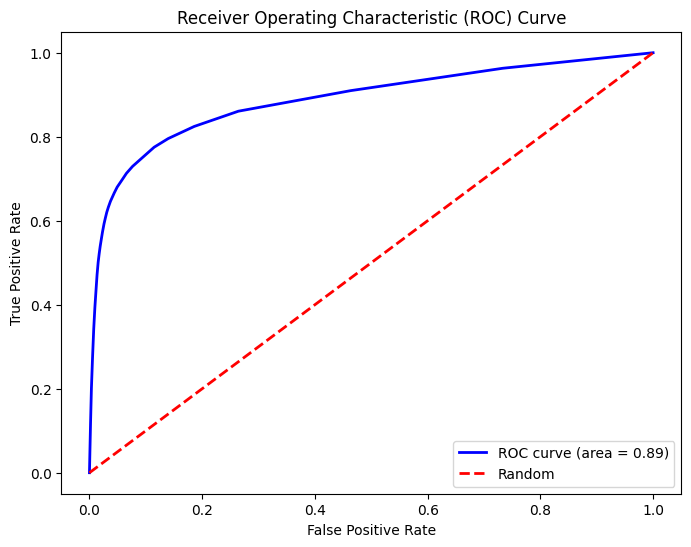

In [37]:
# Create confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Accuracy: {accuracy:.4f}")

# Get the predicted probabilities for the positive class
y_pred_proba = knn.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area for each class
fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=2)
roc_auc = auc(fpr, tpr)

# Plotting the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

""" 
The goal is to predict whether an individual is likely to develop a severe reaction to COVID-19, leading to hospitalization, based solely on their medical history and age.


The model accured an accuracy of 90.38%. This indicates that around 90.38% of the predictions were correct regarding hospitalization based on medical conditions and age.
The precision of 91.52% implies that when the model predicted hospitalization, it was accurate about 91.52% of the time. This shows the reliability of positive predictions. This suggests that the model tended to lean on the safe side of predicting hospitalization. 
With a recall of 97.19%, the model identified 97.19% of the actual hospitalized cases. A higher recall means fewer actual cases of hospitalization were missed (lower false negatives). This indicates that the model predicts (or recommends) hospitalization frequently enough to catch 97% of true hospitalizations. 

The Area Under the Curve (AUC) of 0.89 indicates decent discriminative ability, distinguishing between hospitalized and non-hospitalized individuals based on medical history and age.


The model exhibits strong discrimination and relatively high accuracy in predicting hospitalization based on medical history and age.
However, despite the high accuracy, precision, and recall, there is still room for improvement. Misclassifications could have critical implications, especially if the model misses actual severe cases (false negatives).
It demonstrates commendable performance in predicting hospitalization based on medical conditions and age. 
However, considering the critical nature of predicting severe COVID-19 reactions, further refinements might be necessary to minimize false negatives and ensure a higher recall rate, thereby enhancing its reliability in identifying severe cases that warrant medical attention. 
Additionally, incorporating more features or domain-specific information could enhance the model's predictive power. Perhaps another model, such as Random Forest, would be good to deploy, as it has a higher complexity and has more tunable hyperparameters."""

In [38]:
'''
In comparing these two models, we are looking at two different metrics. 
The first one, while it has higher precision, accuracy, and recall, may not be as useful in identifying high-risk patients, for it factors in mainly your experience at the hospital.
On top of this, the model is predicting likelihood of death from hospital experience. 
This is not necessarily indicative of whether a patient is likely to need advanced treatment or care, because we're gauging the metric based on clearly evident, post-hospitalization indicators of risk.
So, while this model is good for predicting your survival chance based on hospital experience and medical history, that might not be so useful if your goal is to identify risk based on patient medical history.

Therefore, if your goal is to predict patient risk, you may be more inclined to use the second model. While it is less accurate, precise, and recallable overall, it does a better job of at determining patient risk.
In the second model, we are solely using medical history (as well as age) to predict patient type, which is hospitalization status.
This provides more utility for people assessing patient risk, as we are now strictly evaluating whether or not someone would be likely to need advanced care at the hospital.
Indeed, there is great room for imporvement in the second model. 
It tends to overpredict hospitalization, reducing the precision of the predictions.
This can be problematic, as those who may not need hospitalization are taking up valuable resources that others may depend on for their lives.
While it does have a high recall, the 3% that is misses may actually need hospitalization, while the 9% or so that don't need hospitalization may be taking up the 3%'s valuable resources.

In order to potentially increase these metrics, we may consider a few things: 
Increasing the number of predictive features (such as sex, pregnancy, tobacco, asthma, and obesity) may yield higher predictive power.
Increasing the number of nearest neighbors may also reduce the number of false negatives, which is important when your goal is to save lives. 
Deploying a more complex model, such as a Random Forest, may yield higher predictive value as well, for they tend to be more sculptable with hyperparameters.
However, they are also more computationally expensive, especially when deployed using exhaustive tuning to perfect hyperparamers.
'''

''